In [1]:
"""
VAE + GP emulation, only use pre-trained VAE models
"""
##### Packages ###############
import numpy as np  
import time
import pickle
import os
from sklearn.decomposition import PCA
import gpflow
import scipy.signal

import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from itertools import cycle
import matplotlib.ticker as ticker
from pathlib import Path
from matplotlib import gridspec

import SetPub
SetPub.set_pub()

import params

from keras.models import load_model


Using TensorFlow backend.


In [2]:
###################### PARAMETERS ##############################

original_dim = params.original_dim # 2549
intermediate_dim2 = params.intermediate_dim2 # 1024
intermediate_dim1 = params.intermediate_dim1 # 512
intermediate_dim = params.intermediate_dim # 256
latent_dim = params.latent_dim # 10

ClID = params.ClID
num_train = params.num_train # 512
num_test = params.num_test # 32
num_para = params.num_para # 5

batch_size = params.batch_size # 8
num_epochs = params.num_epochs # 100
epsilon_mean = params.epsilon_mean # 1.0
epsilon_std = params.epsilon_std # 1.0
learning_rate = params.learning_rate # 1e-3
decay_rate = params.decay_rate # 0.0

noise_factor = params.noise_factor # 0.00

######################## I/O ##################################

DataDir = params.DataDir
PlotsDir = params.PlotsDir
ModelDir = params.ModelDir

fileOut = params.fileOut

In [3]:

# ----------------------------- i/o ------------------------------------------

Trainfiles = np.loadtxt(DataDir + 'P'+str(num_para)+ClID+'Cl_'+str(num_train)+'.txt')
Testfiles = np.loadtxt(DataDir + 'P'+str(num_para)+ClID+'Cl_'+str(num_test)+'.txt')

x_train = Trainfiles[:, num_para+2:]
x_test = Testfiles[:, num_para+2:]
y_train = Trainfiles[:, 0: num_para]
y_test =  Testfiles[:, 0: num_para]

print(x_train.shape, 'train sequences')
print(x_test.shape, 'test sequences')
print(y_train.shape, 'train sequences')
print(y_test.shape, 'test sequences')

ls = np.loadtxt(DataDir+'P'+str(num_para)+'ls_'+str(num_train)+'.txt')[2:]

#------------------------- SCALAR parameter for rescaling -----------------------
#### ---- All the Cl's are rescaled uniformly #####################

'''
minVal = np.min( [np.min(x_train), np.min(x_test ) ])
meanFactor = 1.1*minVal if minVal < 0 else 0
# meanFactor = 0.0
print('-------mean factor:', meanFactor)
x_train = x_train - meanFactor #/ 255.
x_test = x_test - meanFactor #/ 255.

# x_train = np.log10(x_train) #x_train[:,2:] #
# x_test =  np.log10(x_test) #x_test[:,2:] #

normFactor = np.max( [np.max(x_train), np.max(x_test ) ])
# normFactor = 1
print('-------normalization factor:', normFactor)
x_train = x_train.astype('float32')/normFactor #/ 255.
x_test = x_test.astype('float32')/normFactor #/ 255.


np.savetxt(DataDir+'meanfactorP'+str(num_para)+ClID+'_'+ fileOut +'.txt', [meanFactor])
np.savetxt(DataDir+'normfactorP'+str(num_para)+ClID+'_'+ fileOut +'.txt', [normFactor])

'''
#########  New l-dependant rescaling (may not work with LSTMs) ###########
#### - --   works Ok with iid assumption ############


minVal = np.min( [np.min(x_train, axis = 0), np.min(x_test , axis = 0) ], axis=0)
#meanFactor = 1.1*minVal if minVal < 0 else 0
# meanFactor = 0.0
meanFactor = 1.1*minVal
print('-------mean factor:', meanFactor)
x_train = x_train - meanFactor #/ 255.
x_test = x_test - meanFactor #/ 255.

# x_train = np.log10(x_train) #x_train[:,2:] #
# x_test =  np.log10(x_test) #x_test[:,2:] #

normFactor = np.max( [np.max(x_train, axis = 0), np.max(x_test, axis = 0 ) ], axis = 0)
# normFactor = 1
print('-------normalization factor:', normFactor)
x_train = x_train.astype('float32')/normFactor #/ 255.
x_test = x_test.astype('float32')/normFactor #/ 255.


np.savetxt(DataDir+'meanfactorPArr'+str(num_para)+ClID+'_'+ fileOut +'.txt', [meanFactor])
np.savetxt(DataDir+'normfactorPArr'+str(num_para)+ClID+'_'+ fileOut +'.txt', [normFactor])


##############################################
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


# # Trying to get x_train ~ (-1, 1) -- doesn't work well
# x_mean = np.mean(x_train, axis = 0)
# x_train = x_train - x_mean
# x_test = x_test - x_mean


## ADD noise
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
# # x_train_noisy = np.clip(x_train_noisy, 0., 1.)
# # x_test_noisy = np.clip(x_test_noisy, 0., 1.)


# x_train_noisy = K.cast_to_floatx(x_train_noisy)
# x_train = K.cast_to_floatx(x_train)
# ------------------------------------------------------------------------------

(1024, 2549) train sequences
(25, 2549) test sequences
(1024, 5) train sequences
(25, 5) test sequences
-------mean factor: [460.157 443.387 425.523 ...  32.563  32.487  32.41 ]
-------normalization factor: [2551.947 2315.169 2112.938 ...  124.727  124.525  124.319]


In [4]:

LoadModel = True
if LoadModel:

    # fileOut = 'VanillaModel_tot'+str(num_train)+'_batch'+str(batch_size)+'_lr'+str( learning_rate)+'_decay'+str(decay_rate)+'_z'+str(latent_dim)+'_epoch'+str(num_epochs)

    # vae = load_model(ModelDir + 'fullAE_' + fileOut + '.hdf5')
    encoder = load_model(ModelDir + 'EncoderP'+str(num_para)+ClID+'_' + fileOut + '.hdf5')
    decoder = load_model(ModelDir + 'DecoderP'+str(num_para)+ClID+'_' + fileOut + '.hdf5')
    history = np.loadtxt(ModelDir + 'TrainingHistoryP'+str(num_para)+ClID+'_'+fileOut+'.txt')



# # ------------------------------------------------------------------------------


# # ------------------------------------------------------------------------------
encoded_xtrain = np.loadtxt(DataDir + 'encoded_xtrainP'+str(num_para)+ClID+'_'+ fileOut +'.txt')
encoded_xtest = np.loadtxt(DataDir+'encoded_xtestP'+str(num_para)+ClID+'_'+ fileOut +'.txt')



Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.
/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
y_train.shape

(1024, 5)

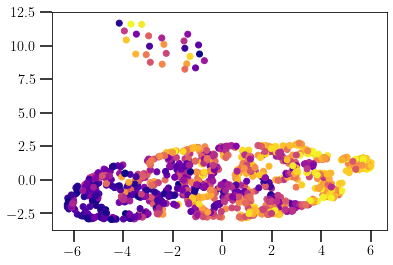

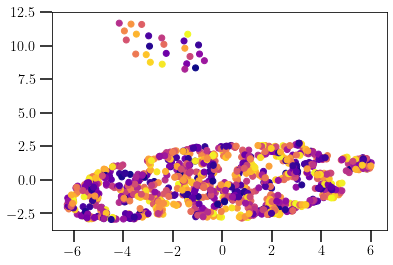

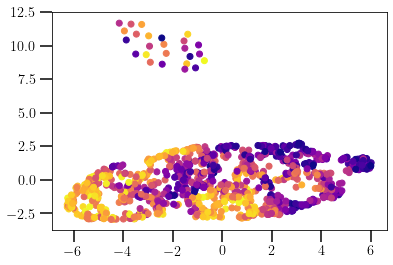

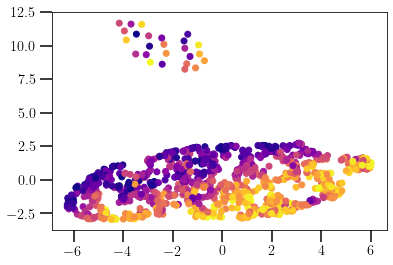

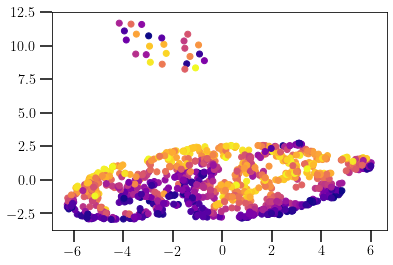

In [14]:
import umap
reducer = umap.UMAP()   
embedding = reducer.fit_transform(encoded_xtrain) 
embedding2 = reducer.fit_transform(encoded_xtest) 

    
plt.figure(2)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train[:,0])
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=y_test[:,0])

plt.figure(3)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train[:,1])
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=y_test[:,1])

plt.figure(4)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train[:,2])
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=y_test[:,2])

plt.figure(5)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train[:,3])
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=y_test[:,3])

plt.figure(6)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train[:,4])
plt.scatter(embedding2[:, 0], embedding2[:, 1], c=y_test[:,4])

    

In [ ]:
# loadFile = np.loadtxt(fileIn)
# PmPl_all = loadFile[:, 1:].T
# kvals = loadFile[:,0]
nRankMax = [2, 4, 8, 12, 16, 32][2] 
del_idx  = []
GPmodel = ModelDir + 'GPflow_modelVAEP' +str(num_para)+ClID+'_'+ 'Rank' + str(nRankMax) + fileOut
PmPl_all = x_train_noisy
parameter_array_all = y_train
y_train = PmPl_all

# parameter_array_all = np.loadtxt(paramIn)



############## rescaling ##############


def rescale01(f):
    return np.min(f), np.max(f), (f - np.min(f)) / (np.max(f) - np.min(f))


def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)
#     return f*(fmax - fmin) + fmin


lhd = np.zeros_like(parameter_array_all)
lhdmin = np.zeros_like(parameter_array_all[1])
lhdmax = np.zeros_like(parameter_array_all[1])

for i in range(parameter_array_all.shape[1]):
    lhdmin[i], lhdmax[i], lhd[:, i] = rescale01(parameter_array_all[:, i])
   

parameter_array_all = lhd


############## rescaling ##############




############## rescaling ##############


## Removing hold-out test points
parameter_array = np.delete(parameter_array_all, del_idx, axis=0)
PmPl = np.delete(PmPl_all, del_idx, axis=0)

# y_train = PmPl


In [ ]:
############################# Plot the input parameter distribution ##############################

allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$f_{R_0}$', r'$n$']


lhd = np.zeros_like(parameter_array_all)
for i in range(parameter_array_all.shape[1]):
    _,_,lhd[:, i] = rescale01(parameter_array_all[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(10, 10) )
    plt.suptitle('lhc design (rescaled parameters)', fontsize = 28)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            # print(i, j)
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)


    plt.show()


plot_params(lhd)

In [ ]:
########################### PCA ###################################
# set up pca compression


def PCA_compress(x, nComp):
    # x is in shape (nparams, nbins)
    pca_model = PCA(n_components=nComp)
    principalComponents = pca_model.fit_transform(x)
    pca_bases = pca_model.components_

    print("original shape:   ", x.shape)
    print("transformed shape:", principalComponents.shape)
    print("bases shape:", pca_bases.shape)

    pickle.dump(pca_model, open(ModelDir + 'GPy_PCA_model' + str(nRankMax), 'wb'))

    return pca_model, np.array(principalComponents), np.array(pca_bases)


######################## GP FITTING ################################

## Build GP models
# This is evaluated only once for the file name. GP fitting is not required if the file exists.
  

def GPflow_fit(parameter_array, weights, fname= GPmodel):
    kern = gpflow.kernels.Matern52(input_dim = np.shape(parameter_array)[1], ARD=True)
#     m1 = GPy.models.GPRegression(parameter_array, weights, kernel=kern)
    m = gpflow.models.GPR(parameter_array, weights, kern=kern, mean_function=None)
#     print_summary(m)
    m.likelihood.variance.assign(0.01)
#     m.kern.lengthscales.assign([0.3, 0.1, 0.2, 0.3, 0.1])
    m.kern.lengthscales.assign([ 38, 192, 98, 30, 129])
    
    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(m)
    m.as_pandas_table()

    print(f'GPR lengthscales =', m.kern.lengthscales.value)

    
    path = Path(GPmodel)
    if path.exists():
        path.unlink()
    
    saver = gpflow.saver.Saver()
    saver.save(fname + str(nRankMax), m)
    



In [ ]:
######################## GP PREDICTION FUNCTIONS ###############################


def GPy_predict(para_array):
    m1p = m1.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(para_array):
    if len(para_array.shape) == 1:
        para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
        W_predArray, _ = GPy_predict(np.expand_dims(para_array_rescaled, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        x_decoded_scaled = (normFactor*x_decoded) + meanFactor
        return np.squeeze(x_decoded_scaled)#[0]
#         return np.squeeze(x_decoded)#[0]



In [ ]:
# pca_model, pca_weights, pca_bases = PCA_compress(PmPl, nComp=nRankMax)

ifTrain = True

if ifTrain: 
    pca_model, pca_weights, pca_bases = PCA_compress(y_train, nComp=nRankMax)
    GPflow_fit(parameter_array, pca_weights)

In [ ]:
if ifTrain:
    plt.figure(23)
    plt.scatter(pca_weights[0,:],pca_weights[1,:], c = parameter_array[0,:] )
    plt.show()

In [ ]:
if ifTrain:
    import umap
    reducer = umap.UMAP()   
    embedding = reducer.fit_transform(pca_weights)  
    plt.scatter(embedding[:, 0], embedding[:, 1], c=parameter_array[0,:])

    

In [ ]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model_rank' +str(nRankMax)+ '.zip')
# pca_model = pickle.load(open(modelDir + 'PCA_model_rank'+str(nRankMax), 'rb'))

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model'+ str(nRankMax) +'.zip')
# m1 = GPy.models.GPRegression.load_model(GPmodel + '.zip')


para_test = y_test
# x_test = x_test_noisy

ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
saver = gpflow.saver.Saver()

m1 = saver.load(GPmodel + str(nRankMax), context=ctx_for_loading)
m1.clear()
m1.compile()

pca_model = pickle.load(open(ModelDir + 'GPy_PCA_model' + str(nRankMax), 'rb'))

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually

plt.figure(999, figsize=(14, 12))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.02, left=0.2, bottom=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# ax0.set_ylabel(r'$p(x)$', fontsize=25)
# ax1.set_xlabel(r'$x$', fontsize=25)
# ax1.set_ylabel(r'$p_{emu}/p_{num} - 1$', fontsize = 18)


ax0.set_ylabel(r'$l(l+1)C_l/2\pi [\mu K^2]$')

# ax0.set_title( r'$\text{' +fileOut + '}$')

ax1.axhline(y= 0, ls='dotted')
ax1.axhline(y=.001, ls='dashed')
ax1.axhline(y=-0.001, ls='dashed')

ax1.set_xlabel(r'$l$')

ax1.set_ylabel(r'$C_l^{emu} $/$C_l^{camb}$')


# ax1.set_ylim(-5e-2, 5e-2)

# ax0.set_xscale('log')
# ax0.set_yscale('log')
# ax1.set_xscale('log')

ax1.axhline(y=0, ls='dashed')

color_id = 0
test_idx = [0, 1, 2, 3, 4, 5, 6]
for x_id in test_idx:
    color_id = color_id + 1
    time0 = time.time()

    para_test_unscaled = para_test[x_id]
    x_test = (normFactor*x_test_noisy[x_id]) + meanFactor

    x_decoded_new = Emu(para_test_unscaled)

    time1 = time.time()
    print('Time per emulation %0.5f' % (time1 - time0), ' s')
    ax0.plot(ls, x_decoded_new, alpha=1.0, lw = 1.5, ls='--', label='emu', dashes=(10, 10), color=plt.cm.Set1(color_id))

    ax0.plot(ls, x_test, alpha=0.4, label='real', color=plt.cm.Set1(color_id))
    ax1.plot(ls, (x_decoded_new / (x_test) ) - 1, ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))


ax0.set_xticklabels([])
plt.savefig('gpflow_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()

In [ ]:
para_test_unscaled = y_test[1, :]

plt.plot(ls,  Emu(para_test[x_id]) )
plt.plot(ls,  Emu(para_test_unscaled*0.92) )
plt.plot(ls,  x_test*normFactor + meanFactor )
# plt.yscale('log')

In [ ]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

def lnlike(theta, x, y, yerr):
    p1, p2, p3, p4 = theta
    new_params = np.array([p1, p2, p3, p4])    

    model = Emu(new_params)
    return -0.5 * (np.sum(((y - model) / yerr) ** 2.))


In [ ]:


allMax = np.max(para_test, axis = 0)
allMin = np.min(para_test, axis = 0)
allMean = np.mean(para_test, axis = 0)

#allMean = 0.5*(allMax - allMin)

print(allMin)
print(allMax)
print(allMean)
Pk_mean = Emu(allMean) 


PlotCls = True

numPlots = 5

fig, ax = plt.subplots(5,2, figsize = (15,26))
# fig = plt.figure()
# fig.add_subplot(221)   #top left
# fig.add_subplot(222)   #top right
# fig.add_subplot(223)   #bottom left
# fig.add_subplot(224)   #bottom right
# plt.show()
plt.subplots_adjust(wspace=0.25)

if PlotCls:
    for paramNo in range(5):
        print(paramNo)
        para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)

        #plt.figure(32)
        lines = ["-","-.","--",":"]
        linecycler = cycle(lines)
        dashList = [(6,2),(10,1),(5,5),(3,3,2,2),(5,2,20,2)]
        colorList = ['r', 'g', 'k', 'b', 'brown']


        for plotID in range(numPlots):
            para_plot = np.copy(allMean)
            para_plot[paramNo] = para_range[plotID]  #### allMean gets changed everytime!!
            x_decodedGPy = Emu(para_plot) 
            lineObj = ax[4-paramNo,0].plot(ls, x_decodedGPy, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = allLabels[paramNo] + ' = %.1e'%para_range[plotID])
            #ax[paramNo,0].set_ylim(9.9, None)
            #ax[4-paramNo,0].set_yscale('log')
            ax[4-paramNo,0].set_xscale('log')
            ax[4-paramNo,0].set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
            ax[4-paramNo,0].set_xlabel('$k$[h/Mpc]')
            #ticks = np.linspace(np.min(10**x_decodedGPy), np.max(10**x_decodedGPy), 5)
            #ticks = np.array([10, 15, 20, 25, 30, 35, 40])
            #ax[4-paramNo,0].set_yticks(ticks, minor = True)
            ax[4-paramNo,0].set_yticks([], minor = True)
            ax[4-paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            ax[4-paramNo,0].legend()
            #ax[paramNo,0].legend(title = allLabels[paramNo])
            #ax[paramNo,1].set_yscale('log')
            ax[4-paramNo,1].set_xscale('log')
            ax[4-paramNo,1].set_ylabel(r'$\Delta f / f_0$')
            ax[4-paramNo,1].set_xlabel('$k$[h/Mpc]')
            #ax[paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            #ax[paramNo,0].legend(title = allLabels[paramNo])
            ax[4-paramNo,1].plot(ls, (x_decodedGPy)/(Pk_mean) - 1, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = para_range[plotID] )


#         start, end = ax[4-paramNo, 0].get_ylim()
#         ax[4-paramNo, 0].yaxis.set_ticks( (np.arange(start, end, 0.1)))
#         ax[4-paramNo, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


fig.savefig(PlotsDir + "sensitivity_snap" + ".png",  bbox_inches="tight", dpi=200)

plt.show()




In [ ]:
from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook, output_file
from bokeh.plotting import figure
output_notebook()

x = ls
y = Emu(para_test[2,:])#/(Pk_mean) - 1 


# p = figure(title="emulated P(k) ratio", plot_height=500, plot_width=600, y_range=(1,1.8), background_fill_color='white')
p = figure(title="emulated P(k) ratio", plot_height=500, plot_width=600, background_fill_color='white')

r = p.line(x, y, color='black', line_width=1.5, alpha=0.8)

p1min, p2min, p3min, p4min, p5min = para_test.min(axis = 0)
p1max, p2max, p3max, p4max, p5max = para_test.max(axis = 0)
p1mean, p2mean, p3mean, p4mean, p5mean = para_test.mean(axis = 0)

def update(p1=p1mean , p2=p2mean, p3=p3mean, p4=p4mean, p5=p5mean):
#     if   f == "sin": func = np.sin
#     elif f == "cos": func = np.cos
    r.data_source.data['y'] = Emu(np.array([p1, p2, p3, p4, p5]))#/Pk_mean - 1
    push_notebook()
    
    

show(p, notebook_handle=True)


interact(update, p1=(p1min,p1max), p2=(p2min,p2max), p3=(p3min, p3max), p4 = (p4min, p4max), p5 = (p5min, p5max))

# output_file( modelDir + "emu.html")
